In [1]:
import os
import shutil

# Specify the directory path
working_dir = '/kaggle/working/'

# Delete all files and subdirectories in the directory
for filename in os.listdir(working_dir):
    file_path = os.path.join(working_dir, filename)
    try:
        if os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directory and its contents
        else:
            os.remove(file_path)  # Remove file
    except Exception as e:
        print(f"Error removing {file_path}: {e}")


In [2]:
!pip install -q git+https://github.com/PyTorchLightning/pytorch-lightning
!pip install -q git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -q git+https://github.com/albumentations-team/albumentations
!pip install -q torchinfo

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 13.5 MB/s eta 0:00:00


In [3]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from torch import nn
from tqdm.notebook import tqdm

import random
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nnd
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp

In [4]:
IMAGE_SIZE = 512
BATCH_SIZE = 7
EPOCHS = 500

color_dict = pd.read_csv('../input/deepglobe-land-cover-classification-dataset/class_dict.csv')
CLASSES = color_dict['name']
print(color_dict)

               name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0


In [5]:
from glob import glob
from sklearn.utils import shuffle

pd_dataset = pd.DataFrame({
    'IMAGES': sorted(glob("../input/deepglobe-land-cover-classification-dataset/train/*.jpg")), 
    'MASKS': sorted(glob("../input/deepglobe-land-cover-classification-dataset/train/*.png"))
})
pd_dataset = shuffle(pd_dataset)
pd_dataset.reset_index(inplace=True, drop=True)
pd_dataset.head()

,IMAGES,MASKS
0,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
1,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
2,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
3,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
4,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...


In [6]:
from sklearn.model_selection import train_test_split

pd_train, pd_test = train_test_split(pd_dataset, test_size=0.10, random_state=42)
pd_train, pd_val = train_test_split(pd_train, test_size=0.10, random_state=42)

print("Training set size:", len(pd_train))
print("Validation set size:", len(pd_val))
print("Testing set size:", len(pd_test))

Training set size: 649
Validation set size: 73
Testing set size: 81


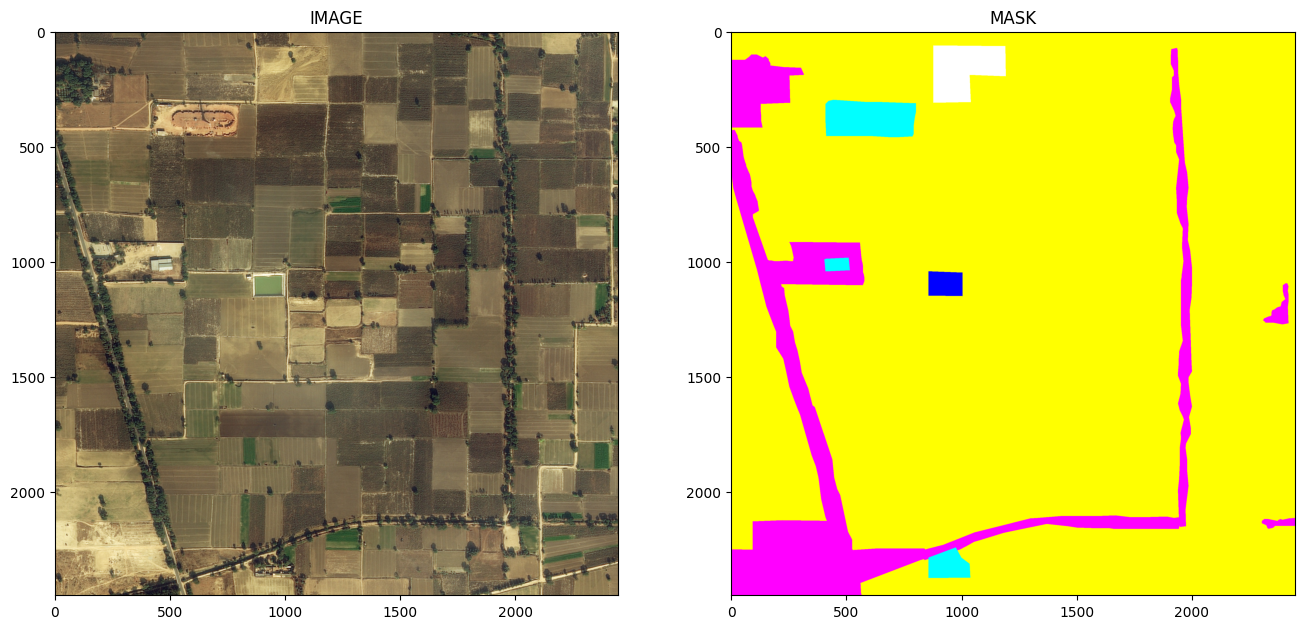

In [7]:
index = 0

sample_img = cv2.imread(pd_train.iloc[index].IMAGES)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

sample_msk = cv2.imread(pd_train.iloc[index].MASKS)
sample_msk = cv2.cvtColor(sample_msk, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

ax1.set_title('IMAGE')
ax1.imshow(sample_img)

ax2.set_title('MASK')
ax2.imshow(sample_msk)

In [8]:
def rgb2category(rgb_mask):
    category_mask = np.zeros(rgb_mask.shape[:2], dtype=np.int8)
    for i, row in color_dict.iterrows():
        category_mask += (np.all(rgb_mask.reshape((-1, 3)) == (row['r'], row['g'], row['b']), axis=1).reshape(rgb_mask.shape[:2]) * i)
    return category_mask

def category2rgb(category_mask):
    rgb_mask = np.zeros(category_mask.shape[:2] + (3,))
    for i, row in color_dict.iterrows():
        rgb_mask[category_mask==i] = (row['r'], row['g'], row['b'])
    return np.uint8(rgb_mask)

In [9]:
import albumentations as aug
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'

train_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.HorizontalFlip(p=0.5),
    aug.VerticalFlip(p=0.5),
    aug.RandomRotate90(p=0.5),                     # Added rotation invariance
    aug.RandomBrightnessContrast(p=0.3),
    aug.GaussNoise(var_limit=(10.0, 50.0), p=0.2),   # Added noise injection
    aug.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),  # Simulate elastic deformations

])

test_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.RandomBrightnessContrast(p=0.3)
])
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

In [10]:
from torch.utils.data import Dataset, DataLoader

class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations=None, preprocessing=None):
        self.df = df
        self.augmentations = augmentations
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]

        image = cv2.imread(row.IMAGES)
        image = image[:,:,::-1]
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(row.MASKS)
        # mask = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = mask[:,:,::-1]
        
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = data['image'], data['mask']
        
        mask = rgb2category(mask)

        image = np.transpose(image, (2, 0, 1)).astype(np.float64)
        mask = np.expand_dims(mask, axis=0)

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask).long()

        return image, mask

In [11]:
class SegmentationDataModule(pl.LightningDataModule):
    def __init__(self, pd_train, pd_val, pd_test, batch_size=10):
        super().__init__()
        self.pd_train = pd_train
        self.pd_val = pd_val
        self.pd_test = pd_test
        self.batch_size=batch_size

    def setup(self, stage=None):
        self.train_dataset = SegmentationDataset(self.pd_train, train_augment, get_preprocessing(preprocessing_fn))
        self.val_dataset = SegmentationDataset(self.pd_val, test_augment, get_preprocessing(preprocessing_fn))
        self.test_dataset = SegmentationDataset(self.pd_test, test_augment, get_preprocessing(preprocessing_fn))

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size // 2, shuffle=False, num_workers=1)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size // 2, shuffle=False, num_workers=1)

In [12]:
data_module = SegmentationDataModule(pd_train, pd_val, pd_test, batch_size=BATCH_SIZE)
data_module.setup()

In [13]:
image, mask = next(iter(data_module.train_dataloader()))
image.shape, mask.shape

(torch.Size([7, 3, 512, 512]), torch.Size([7, 1, 512, 512]))

In [14]:
image_val, mask_val = next(iter(data_module.val_dataloader()))
image_val.shape, mask_val.shape

(torch.Size([3, 3, 512, 512]), torch.Size([3, 1, 512, 512]))

In [15]:
image_test, mask_test = next(iter(data_module.test_dataloader()))
image_test.shape, mask_test.shape


(torch.Size([3, 3, 512, 512]), torch.Size([3, 1, 512, 512]))

In [16]:
from segmentation_models_pytorch import DeepLabV3Plus
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import get_stats, iou_score, accuracy, precision, recall, f1_score
import torch
import pytorch_lightning as pl

class SegmentationModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = DeepLabV3Plus(
            encoder_name=ENCODER,
            encoder_weights=ENCODER_WEIGHTS,
            in_channels=3,
            classes=len(CLASSES),
            activation="softmax"
        )

        self.freeze_encoder()  # Đóng băng encoder để chỉ fine-tune decoder

        self.criterion = DiceLoss(mode="multiclass", from_logits=False)

    def freeze_encoder(self):
        """Đóng băng encoder, chỉ fine-tune decoder và segmentation head."""
        for param in self.model.encoder.parameters():
            param.requires_grad = False  # Đóng băng encoder

        for param in self.model.decoder.parameters():
            param.requires_grad = True  # Fine-tune decoder

        for param in self.model.segmentation_head.parameters():
            param.requires_grad = True  # Fine-tune segmentation head

        print("Encoder is frozen. Only decoder and segmentation head are trainable.")

    def forward(self, inputs, targets=None):
        outputs = self.model(inputs)
        if targets is not None:
            loss = self.criterion(outputs, targets)
            tp, fp, fn, tn = get_stats(
                outputs.argmax(dim=1).unsqueeze(1).type(torch.int64), 
                targets, 
                mode='multiclass', 
                num_classes=len(CLASSES)
            )
            metrics = {
                "Accuracy": accuracy(tp, fp, fn, tn, reduction="micro-imagewise"),
                "IoU": iou_score(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Precision": precision(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Recall": recall(tp, fp, fn, tn, reduction="micro-imagewise"),
                "F1score": f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
            }
            return loss, metrics, outputs
        else: 
            return outputs

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, self.parameters()), 
            lr=1e-5,  
            weight_decay=1e-4  
        )

        return optimizer

    def training_step(self, batch, batch_idx):
        images, masks = batch
        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "train/Loss": loss,
            "train/IoU": metrics['IoU'],
            "train/Accuracy": metrics['Accuracy'],
            "train/Precision": metrics['Precision'],
            "train/Recall": metrics['Recall'],
            "train/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "val/Loss": loss,
            "val/IoU": metrics['IoU'],
            "val/Accuracy": metrics['Accuracy'],
            "val/Precision": metrics['Precision'],
            "val/Recall": metrics['Recall'],
            "val/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, masks = batch
        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "test/Loss": loss,
            "test/IoU": metrics['IoU'],
            "test/Accuracy": metrics['Accuracy'],
            "test/Precision": metrics['Precision'],
            "test/Recall": metrics['Recall'],
            "test/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss


In [17]:
from torchinfo import summary

model = SegmentationModel()
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

Encoder is frozen. Only decoder and segmentation head are trainable.


Layer (type:depth-idx)                                       Output Shape              Param #
SegmentationModel                                            [7, 7, 512, 512]          --
├─DeepLabV3Plus: 1-1                                         [7, 7, 512, 512]          --
│    └─ResNetEncoder: 2-1                                    [7, 3, 512, 512]          --
│    │    └─Conv2d: 3-1                                      [7, 64, 256, 256]         (9,408)
│    │    └─BatchNorm2d: 3-2                                 [7, 64, 256, 256]         (128)
│    │    └─ReLU: 3-3                                        [7, 64, 256, 256]         --
│    │    └─MaxPool2d: 3-4                                   [7, 64, 128, 128]         --
│    │    └─Sequential: 3-5                                  [7, 256, 128, 128]        (215,808)
│    │    └─Sequential: 3-6                                  [7, 512, 64, 64]          (1,219,584)
│    │    └─Sequential: 3-7                                  [7, 1024, 

In [18]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val/IoU",
    mode="max"
)

logger = CSVLogger("lightning_logs", name="landcover-classification-log-resnet101")

early_stopping_callback = EarlyStopping(monitor="val/IoU", patience=30)

trainer = pl.Trainer(
    logger=logger,
    log_every_n_steps=31,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=EPOCHS,
    accelerator="gpu",
    devices=1
)

In [19]:
trainer.fit(model, data_module)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [20]:
trainer.test(model, data_module)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy       │    0.9390977621078491     │
│       test/F1score        │    0.7868421077728271     │
│         test/IoU          │    0.6796548962593079     │
│         test/Loss         │    0.43624553084373474    │
│      test/Precision       │    0.7868421077728271     │
│        test/Recall        │    0.7868421077728271     │
└───────────────────────────┴───────────────────────────┘

[{'test/Loss': 0.43624553084373474,
  'test/IoU': 0.6796548962593079,
  'test/Accuracy': 0.9390977621078491,
  'test/Precision': 0.7868421077728271,
  'test/Recall': 0.7868421077728271,
  'test/F1score': 0.7868421077728271}]

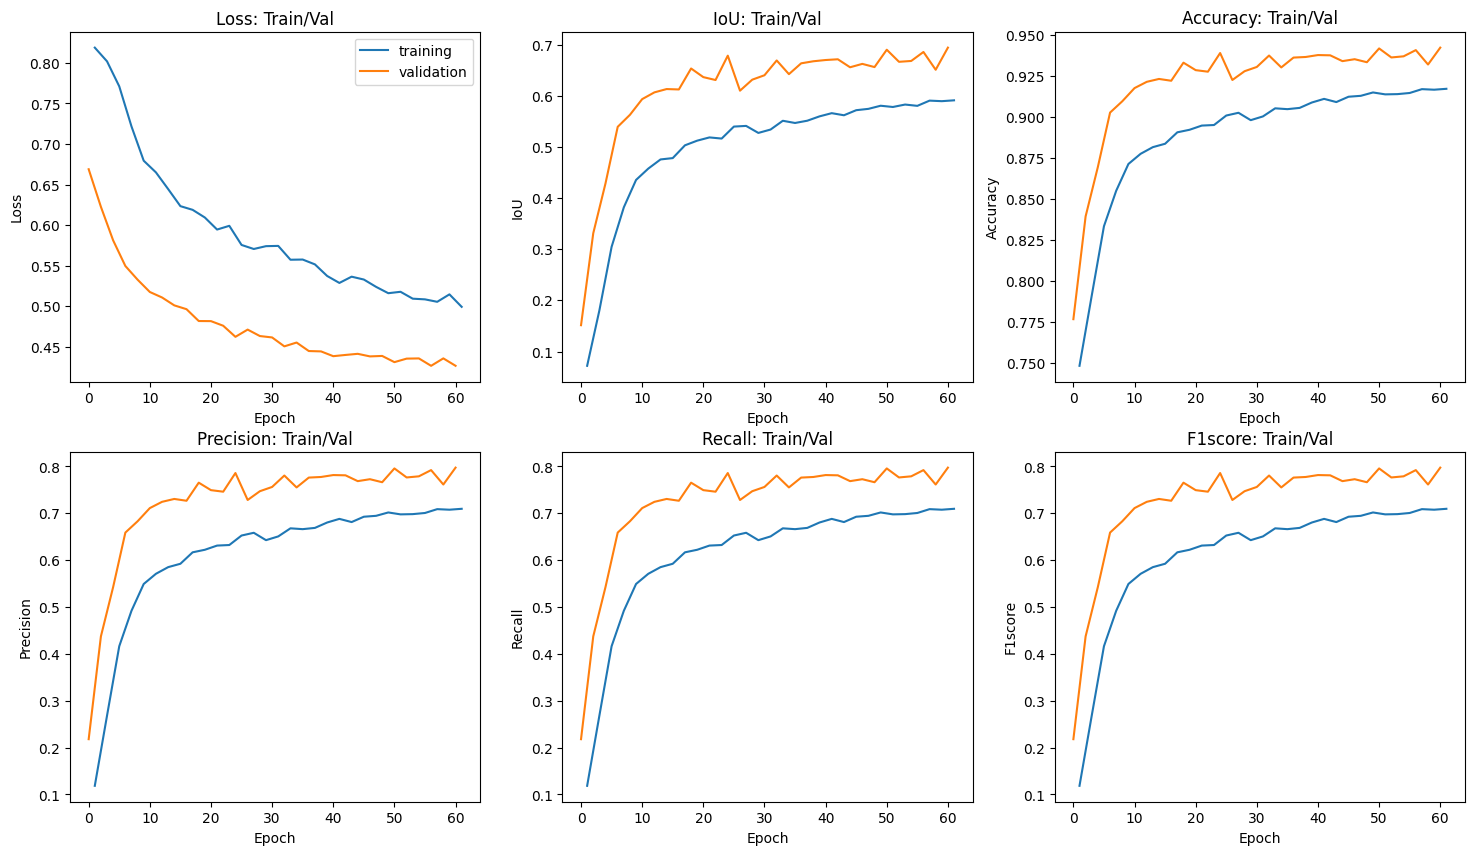

In [21]:
metrics = pd.read_csv("./lightning_logs/landcover-classification-log-resnet101/version_0/metrics.csv")
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
names = ['Loss', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1score']

for axis, name in zip(axes, names):
    axis.plot(metrics[f'train/{name}'].dropna())
    axis.plot(metrics[f'val/{name}'].dropna())
    axis.set_title(f'{name}: Train/Val')
    axis.set_ylabel(name)
    axis.set_xlabel('Epoch')
    ax1.legend(['training', 'validation'], loc="upper right")

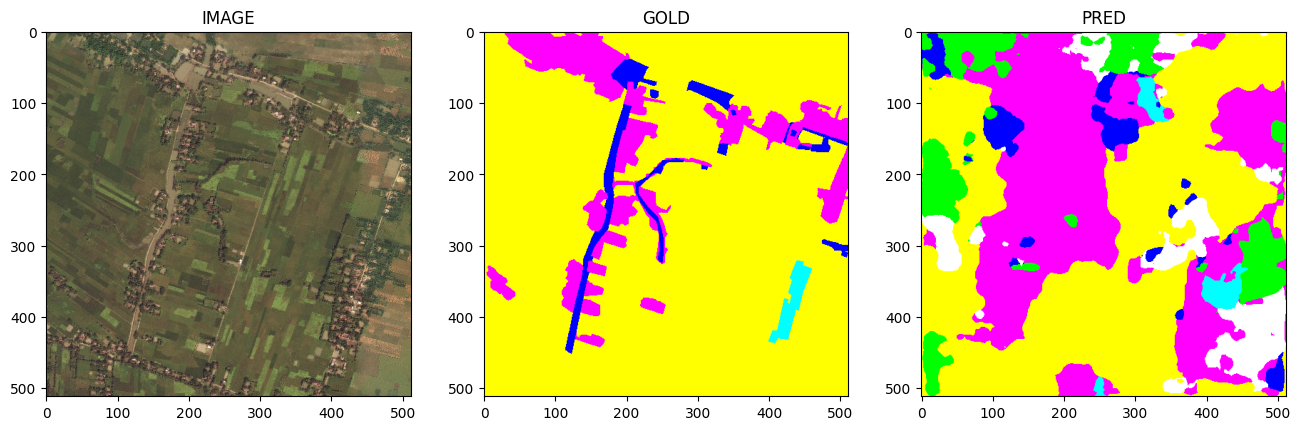

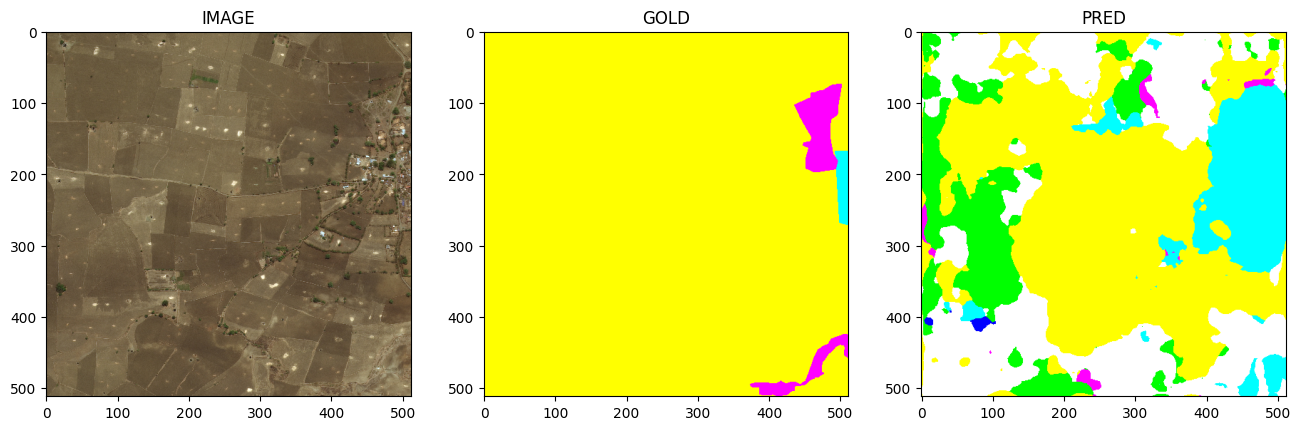

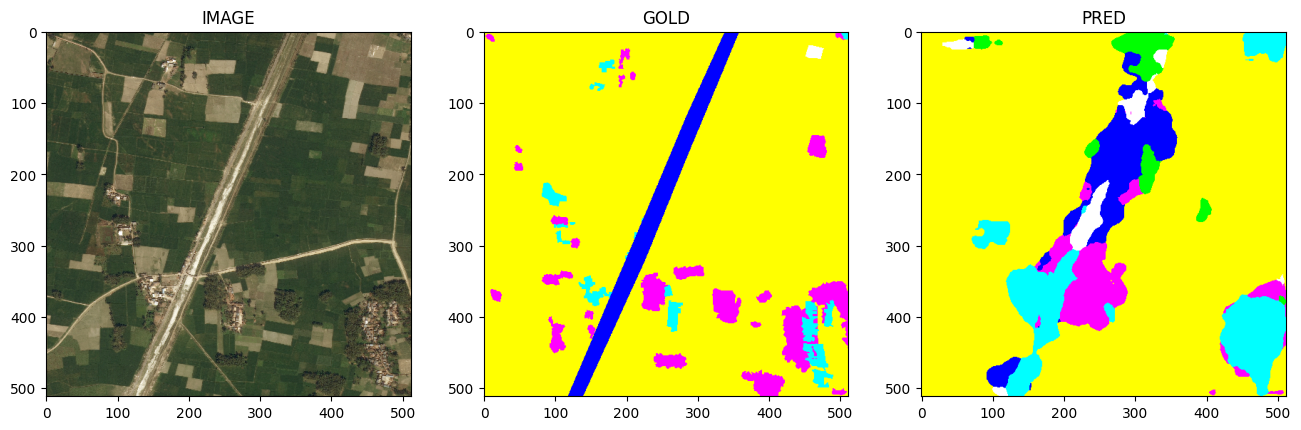

In [22]:
data_module = SegmentationDataModule(pd_train, pd_val, pd_test, batch_size=BATCH_SIZE)
data_module.setup()
image, mask = next(iter(data_module.test_dataloader()))
outputs = model(image)
for i in range(BATCH_SIZE//2):
    pred_category = outputs[i].argmax(dim=0).unsqueeze(1).type(torch.int64).squeeze()
    pred_rgb = category2rgb(pred_category.cpu())
    gold_mask = category2rgb(mask[i].squeeze().cpu())
    test_img = image[i].permute(1,2,0)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 10))
    ax1.set_title('IMAGE')
    ax1.imshow(test_img)

    ax2.set_title('GOLD')
    ax2.imshow(gold_mask)

    ax3.set_title('PRED')
    ax3.imshow(pred_rgb)